In [14]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import models
import util
import os
import config
from config import ATTR_TO_INDEX
import viz
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import data
import sklearn.metrics
from matching import *

df = data.load_all_labs()
df = df.set_index('fname_id')

DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'
reg = 0.1
DIR_GEN = oj(DIRS_GEN, f'generated_images_{reg}')

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
fname_ids = np.array([f[:-4] for f in fname_nps])
idxs_calculated = np.array([int(x) - 1 for x in fname_ids]) # this starts at 0

# trim df to only have the relevant ids
df = df.loc[fname_ids]

# load latents and calculate dists
print('reload latents...')
latents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])
lats = get_lat(latents)
preds = np.ones((lats.shape[0], 6)) #lats @ coefs.T + intercepts.T
weights = np.ones(preds.shape[1])
# print(ATTR_TO_INDEX)
# weights[ATTR_TO_INDEX['skin-color']] = 1e2
vecs = join_vecs(preds, lats, weights)

print('calculating gan dists...')
dists_gan = get_dists(vecs)
print('done!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading cached labels
reload latents...
calculating gan dists...
done!


In [15]:
# load pairwise facial dicts
print('load facial dists')
dists_facial = np.load(open('processed/13_facial_dists_pairwise.npy', 'rb')) # pkl.load()
dists_facial = dists_facial[idxs_calculated]
dists_facial = dists_facial[:, idxs_calculated]
print('facial dists loaded')

load facial dists
facial dists loaded


# preprocess

In [16]:
print(df.shape, df.id.unique().size) 

(16445, 64) 4744


# find best matches

In [91]:
'''
we want to find matched pairs
the pairs should change only one attribute at a time (but we may vary 2 to make a transect)
"main" image is matched stringently
"reference" image is matched more loosely
'''

# specify constraint for reference
def apply_reference_constraints(d):
    REFERENCE_CONSTRAINTS = {
        'Eyeglasses': 0, # default should be no Eyeglasses
    }
    for k in REFERENCE_CONSTRAINTS.keys():
        d = d[d[k] == REFERENCE_CONSTRAINTS[k]]
    return d

# specify things to vary (these should all be binary columns)
attrs_to_vary = ['gender'] # Eyeglasses, gender, Race

# specify whether to require id to be different
# only false for id-preserving attributes, such as Eyeglasses
require_ids_different = True

# specify dists for matching
dists = dists_facial
n = dists.shape[0]
assert df.shape[0] == n

## remove ims with no reference image satisfying reference constraints
idxs_orig = np.ones(n).astype(bool)
for i in tqdm(sorted(df.id.unique())):
    idxs = df.id == i
    d = df[idxs_orig]
    locs = d.index
    
    # only one photo for this id
    if d.shape[0] == 1:
        idxs_orig[locs] = False


    # prune photos if no valid ref
    d_ref = apply_reference_constraints(d)
    
    # don't pick this id if there is no valid ref
    if d_ref.shape[0] < 1:
        idxs_orig[locs] = False

    # don't select ref photo if it's the only one
    elif d_ref.shape[0] == 1:
        idxs_orig[d_ref.index] = False 

100%|██████████| 4744/4744 [01:50<00:00, 42.88it/s]


In [93]:
# find allowed indices for each group
subgroups = {}
for a in attrs_to_vary:
    for val in [0, 1]:
        subgroups[f'{a}_{val}'] = (df[a].values == val) & idxs_orig

matches = []
for match_num in tqdm(range(10)):
    # loop to create best matches
    for i, a in enumerate(attrs_to_vary):
        # this should go in order from smaller groups -> bigger groups
    #     vals = np.argsort([np.sum(subgroups[f'{a}_{val}']) for val in [0, 1]])
    #     for j, val in enumerate([0, 1]):

        ## find best match subject to constraints
        s0 = f'{a}_{0}'
        s1 = f'{a}_{1}'
        idxs0 = subgroups[s0]
        idxs1 = subgroups[s1]
        C = np.sum(idxs1)
        dists_constrained = dists[idxs0][:, idxs1] # (R, C)
        arg = np.argmin(dists_constrained)
        # print(arg, dists_constrained.flatten()[arg], dists_constrained.min())

        # convert match arg back to space without constraints
        arg0 = arg // C
        arg1 = arg % C
        idx0 = np.where(idxs0)[0][arg0]
        idx1 = np.where(idxs1)[0][arg1]

        ## find best reference images

        ## if best reference image isn't great, then continue

        ## save the pairs
        matches.append({
            s0: idx0,
            s1: idx1,
            'dist': dists_constrained[arg0, arg1]
        })

        ## remove them from further consideration
        subgroups[s0][idx0] = False
        subgroups[s1][idx1] = False

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


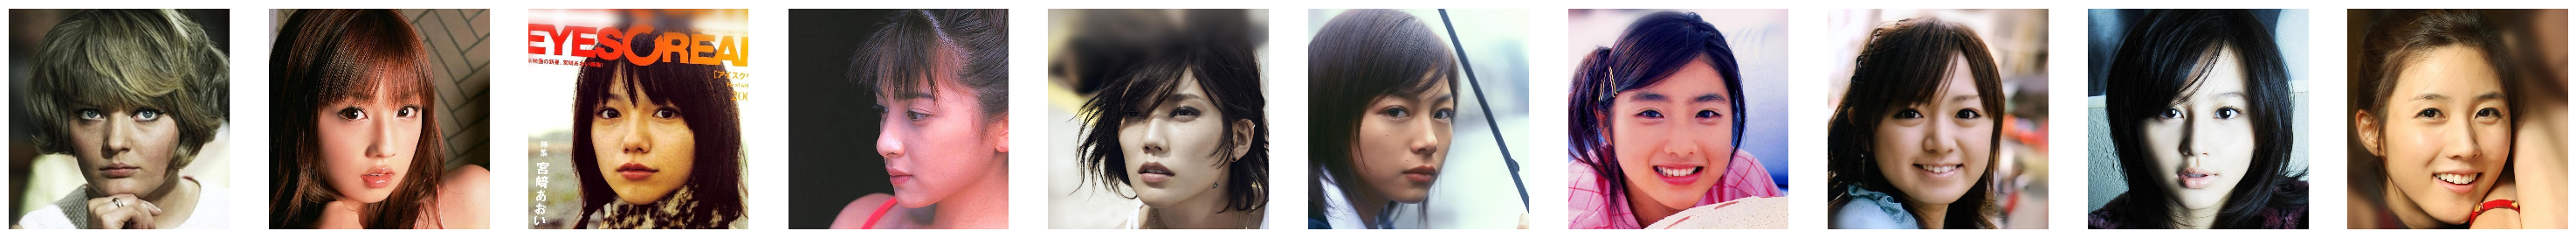

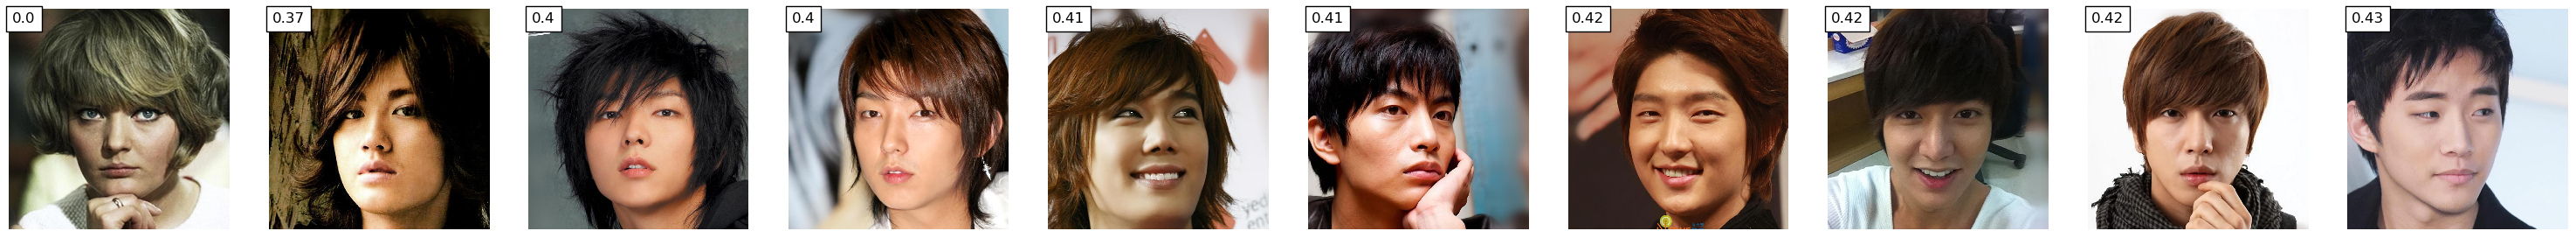

In [94]:
ims0 = []
ims1 = []
dists = []
for match in matches:
    a = 'gender'
    idx0 = match[f'{a}_0']
    idx1 = match[f'{a}_1']
    d0 = df.iloc[idx0]
    d1 = df.iloc[idx1]
    fname0 = d0.fname_final
    fname1 = d1.fname_final
    ims0.append(mpimg.imread(oj(DIR_ORIG, fname0)))
    ims1.append(mpimg.imread(oj(DIR_ORIG, fname1)))
    dists.append(match['dist'])
util.plot_row(ims0)
util.plot_row(ims1, annot_list=np.array(dists).round(2))

# do matching

### find matching for an im

In [ ]:
# img 38 is a good gender example
for im_idx in range(38, 40):
    # if all images are calculated, then this is just 5-char string of im_idx + 1
    fname_id = fname_ids[im_idx] 
    
    # idxs
    dists_im = dists[im_idx]
    
    # select subset of indices to use for matching
    idxs = np.ones(df.shape[0]).astype(bool)
    idxs = (df['gender'] > 0).values
#     idxs = (df['race'] == 'Black').values
#     idxs = (df['Eyeglasses'] > 0).values
    dists_im = dists_im[idxs]
    fname_ids_for_matching = fname_ids[idxs]    
    
    closest_match_vals, closest_matches_fnames = calc_matches(dists_im, fname_ids_for_matching)
    # print(closest_matches_fnames)
    
    # load images
    N_MATCHES_TO_PLOT = 5
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
    im_rec = mpimg.imread(oj(DIR_GEN, f'{fname_id}.png'))
    im_matches = [mpimg.imread(oj(DIR_GEN, f'{fname_match}.png'))
                  for fname_match in closest_matches_fnames[:N_MATCHES_TO_PLOT]]
    
    # plt images
    util.plot_row([im_orig, im_rec] + im_matches, dpi=50)
    plt.show()
    # print(closest_matches, closest_matches_fnames)
# show_matches(dists, DIR_ORIG, DIR_GEN, im_nums=range(5, 10))